<a href="https://colab.research.google.com/github/hookskl/nlp_w_pytorch/blob/main/nlp_w_pytorch_ch8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Sequence Modeling for NLP

## Sequence-to-Sequence Models, Encoder-Decoder Models, and Conditioned Generation

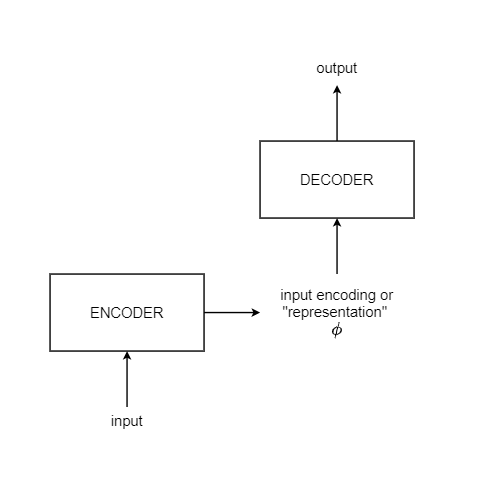

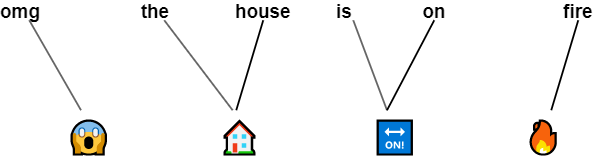

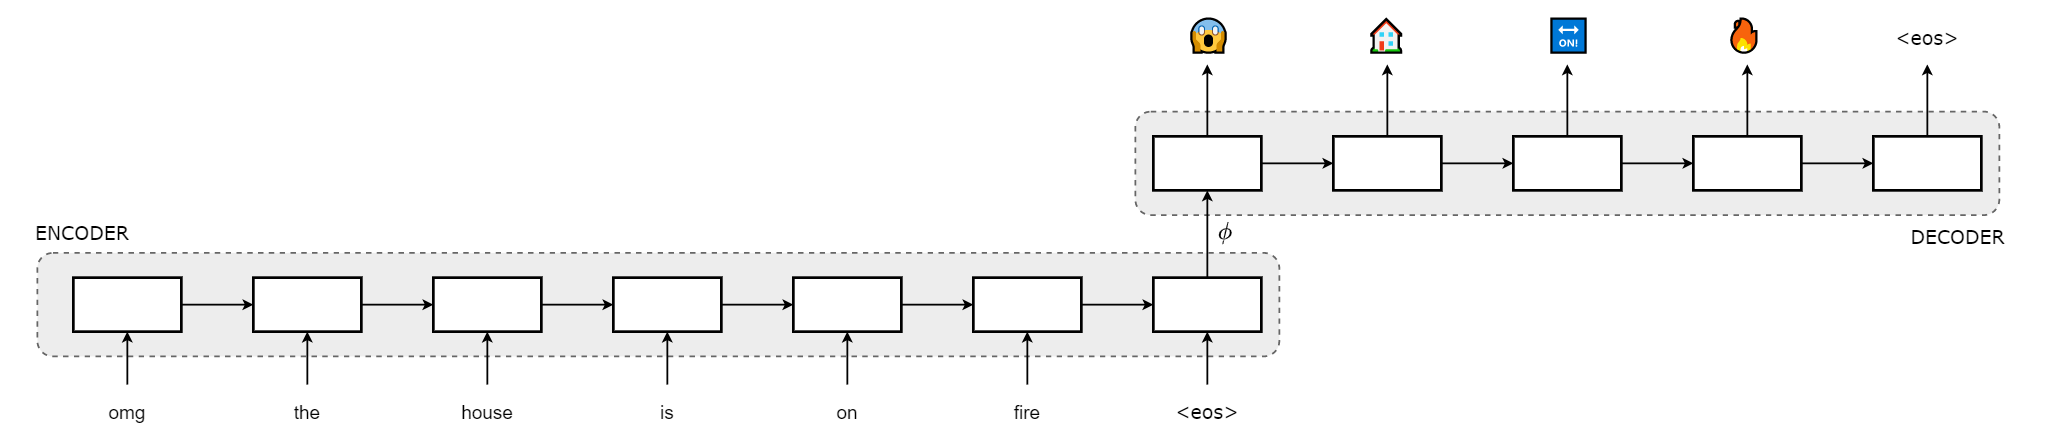

### Capturing More from a Sequence: Bidirectional RNNs

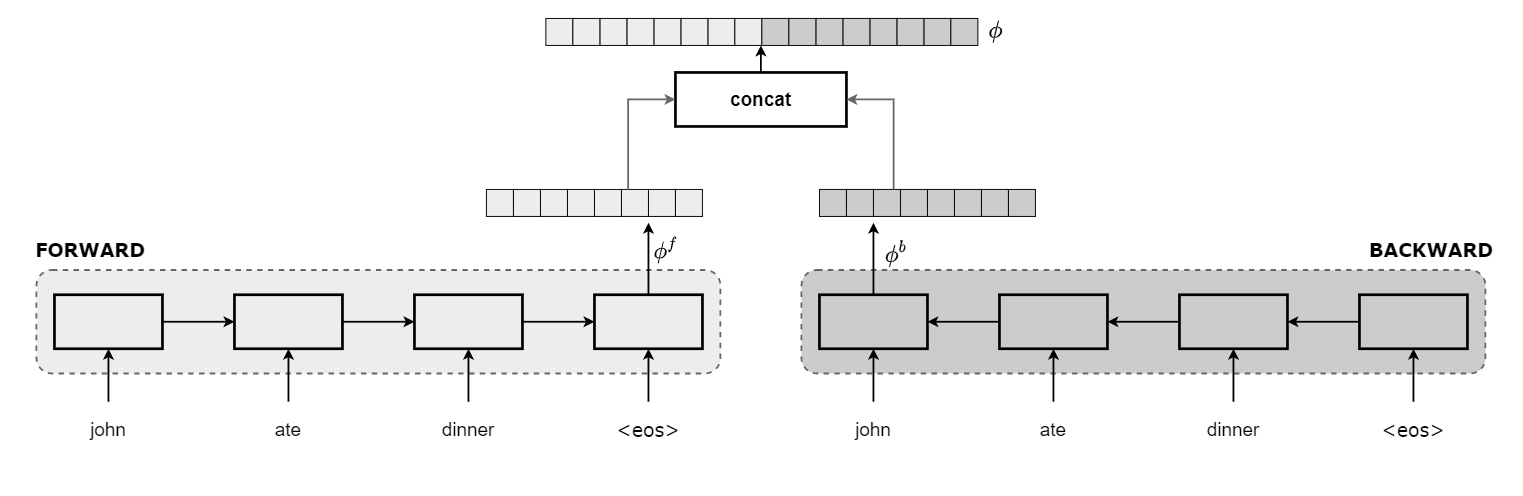

### Capturing More from a Sequence: Attention

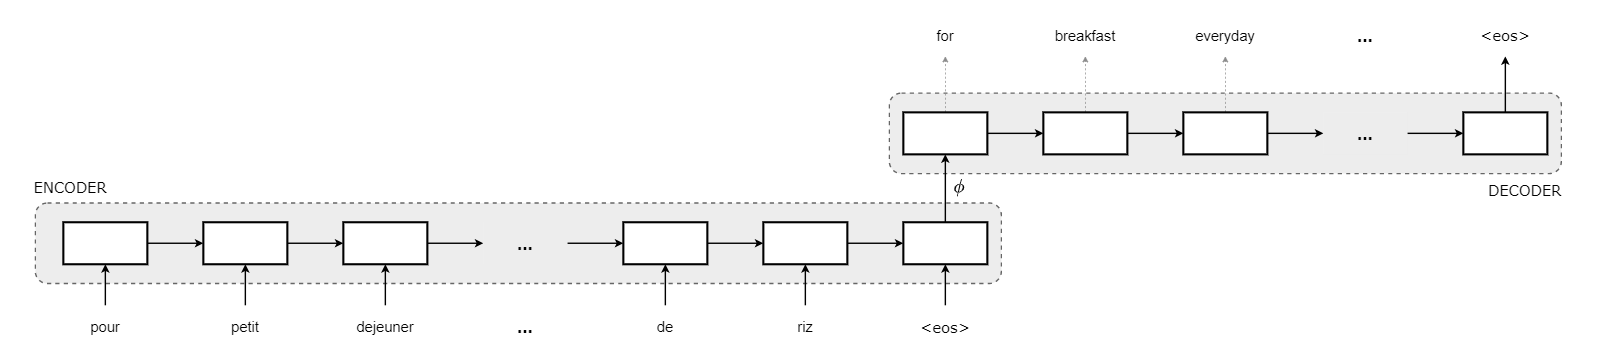

#### Attention in Deep Neural Networks

## Evaluating Sequence Generation Models

### Example: Neural Machine Translation

### The Machine Translation Dataset

### A Vectorization Pipeline for NMT

*Example 8-1. Constructing the `NMTVectorizer`*

```
class NMTVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, source_vocab, target_vocab, max_source_length, 
                 max_target_length):
        """
        Args:
            source_vocab (SequenceVocabulary): maps source words to integers
            target_vocab (SequenceVocabulary): maps target words to integers
            max_source_length (int): the longest sequence in the source dataset
            max_target_length (int); the longest sequence in the target dataset
        """
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

        self.max_source_length = max_source_length
        self.max_target_length = max_target_length

    @classmethod
    def from_dataframe(cls, bitext_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            bitext_df (pandas.DataFrame): the parallel text dataset
        Returns:
            an instance of the NMTVectorizer
        """
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        max_source_length, max_target_length = 0, 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)

        return cls(source_vocab, target_vocab, max_source_length,
                   max_target_length)
```

*Example 8-2. The vectorization functions in the `NMTVectorizer`*

```
class NMTVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    # ...
    def _vectorizer(self, indices, vector_length=-1, mask_index=0):
        """Vectorize the provided indices
        Args:
            indices (list): a list of integers that represent a sequence
            vector_length (int): forces the length of the index vector
            mask_index (int): the mask_index to use; almost always 0
        """
        if vector_length < 0:
            vector_length = len(indices)
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index
        return vector

    def _get_source_indices(self, text):
        """Return the vectorized source text

        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            indices (list): list of integers representing the text
        """
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token)
                       for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices

    def _get_target_indices(self, text):
        """Return the vectorized source text

        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            a tuple (x_indices, y_indices)
                x_indices (list): list of ints; observations in target decoder
                y_indices (list): list of ints; predictions in target decoder
        """
        indices = [self.target_vocab.lookup_vocab(token)
                   for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab_end_seq_index]
        return x_indices, y_indices

    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        """Return the vectorized source and target text

        Args:
            source_text (str): text from the source language
            target_text (str): text from the target language
            use_dataset_max_lengths (bool): whether to use the max vector lengths
        Returns:
            the vectorized data point as a dictionary with the keys:
                source_vector, target_x_vector, target_y_vector, source_length
        """
        source_vector_length = -1
        target_vector_length = -1

        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1

        source_indices = self._get_source_indices(source_text)   
        source_vector = self._vectorize(source_indices,
                                        vector_length=source_vector_length,
                                        mask_index=self.source_vocab.mask_index)

        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                          vector_length=target_vector_length,
                                          mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector,
                "target_x_vector": target_x_vector,
                "target_y_vector": target_y_vector,
                "source_length": len(source_indices)}
```



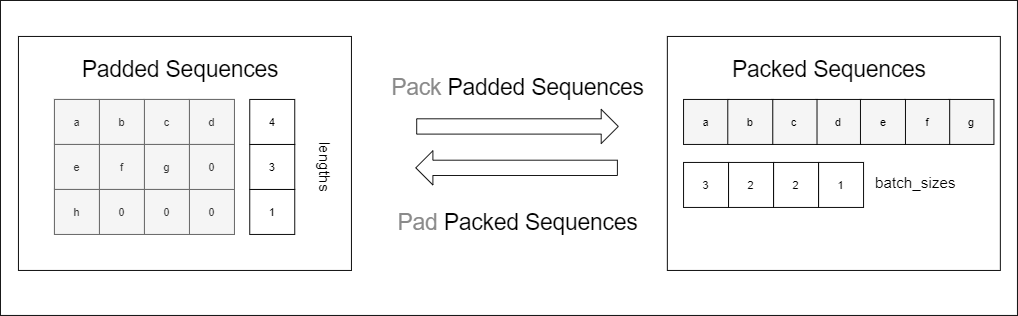

*Example 8-3. Generating minibatches for the NMT*

```
def generate_nmt_batches(dataset, batch_size, shuffle=True,
                         drop_last=True, device='cpu'):
    """A generator function which wraps the PyTorch DataLoader; NMT version"""
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sort_length_indices = lengths.argsort()[::-1].tolist()

        out_data_dict = {}
        for name, tensor in data_dict.items()
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict
```

### Encoding and Decoding in the NMT Model

*Example 8-4. The `NMTModel` encapsulates and coordinates the encoder and decoder in a single `forward()` method*

```
class NMTModel(nn.Module):
    """The Neural Machine Translation Model"""
    def __init__(self, source_vocab_size, source_embedding_size,
                 target_vocab_size, target_embedding_size, encoding_size,
                 target_bos_index):
    """
    Args:
        source_vocab_size (int): number of unique words in source language
        source_embedding_size (int): size of the source embedding vectors
        target_vocab_size (int): number of unqiue words in target language
        target_embedding_size (int): size of the target embedding vectors
        encoding_size (int): size of the encoder RNN
        target_bos_index (int): index for BEGIN-OF-SEQUENCE token
    """
    super(NMTModel, self).__init__()
    self.encoder = NMTEncoder(num_embeddings=source_vocab_size,
                              embedding_size=source_embedding_size,
                              rnn_hidden_size=encoding_size)
    decoding_size = encoding_size * 2
    self.decoder = NMTDecoder(num_embddings=target_vocab_size,
                              embedding_size=target_embedding_size,
                              rnn_hidden_size=decoding_size,
                              bos_index=target_bos_index)

    def forward(self, x_source, x_source_lengths, target_sequence):
        """the forward pass of the model

        Args:
            x_source (torch.Tensor): the source text data tensor
                x_source.shape should be (batch, vectorizer.max_source_length)
            x_source_lengths (torch.Tensor): the length of the sequences in x_source
            target_sequence (torch.Tensor): the target next data tensor
        Returns:
            decoded_states (torch.Tensor): prediction vectors at each output step
        """
        encoder_state, final_hidden_states = self.encoder(x_source,
                                                          x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state,
                                      initial_hidden_state=final_hidden_states,
                                      target_sequence=target_sequence)
        return decoded_states                                                                                                                                      
```

*Example 8-5. The encoder embeds the source words and extracts features with a bi-GRU*

```
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        """
        Args:
            num_embeddings (int): size of source vocabulary
            embedding_size (int): size of the embedding vectors
            rnn_hidden_size (int): size of the RNN hidden state vectors
        """
        super(NMTEncoder, self).__init__()

        self.source_embedding = nn.Embedding(num_embeddings, embedding_size,
                                             padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True,
                            batch_first=True)

    def forward(self, x_source, x_lengths):
        """the forward pass of the model

        Args:
            x_source (torch.Tensor): the input data tensor
                x_source.shape is (batch, seq_size)
            x_lengths (torch.Tensor): vector of lengths for each item in batch
        Returns:
            a tuple: x_unpacked (torch.Tensor), x_birnn_h (torch.Tensor)
                x_unpacked.shape = (batch, seq_size, rnn_hidden_size * 2)
                x_birnn_h.shape = (batch, rnn_hidden_size * 2)
        """
        x_embedded = self.source_embedding(x_source)
        # create PackedSequence; x_packed.data.shape=(number_items,
        #                                    embedding_size)
        x_lengths = x_lengths.detach().cpu().numpy()
        x_packed = pack_padded_sequence(x_embedded, x_lengths, batch_first=True)

        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h = self.birnn(x_packed)
        # permute to (batch_size, num_rnn, feature_size)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)

        # flatten features; reshape to (batch_size, num_rnn * feature_size)
        # (recall: -1 takes the remaining positions,
        #          flattening the twho RNN hidden vectors into 1)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)

        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        return x_unpacked, x_birnn_h
```

*Example 8-6. A simple demonstration of `packed_padded_sequences` and `pad_packed_sequences`*

*Example 8-7. The `NMTDecoder` constructs a target sentence from the encoded source sentence*

```
```

#### A closer look at attention

*Example 8-8. Attention mechanism that does element-wise multiplication and summing more explicitly*

```
```

#### Learning to search and scheduled sampling

*Example 8-9. The decoder with a sampling procedure built into the forward pass*

```
```

### The Training Routine and Results